# Basic Info

## Team 1

- Ted Hsu ([thhsu4@illinois.edu](mailto:thhsu4@illinois.edu))
- Myles Iribarne ([mylesai2@illinois.edu](mailto:mylesai2@illinois.edu))
- Daniel Xu ([dhxu2@illinois.edu](mailto:dhxu2@illinois.edu))

## Paper

Our paper is _Transfer learning for ECG classification_ by Weimann and Conrad <cite data-cite="Weimann:2021wz">[1]</cite>. The project code is available on [Github](https://github.com/kweimann/ecg-transfer-learning/tree/master).

## TODO Video

TODO Include a public link to your project video (Youtube/OneDrive/GDrive etc) at the top of the notebook.


# Introduction
## Background of the problem

- **What type of problem**:

  The problem is to classify Atrial Fibrillation (AF) on electrocardiogram (ECG) recordings.
- **What is the importance/meaning of solving the problem**:

  - A solution to the problem is a tool that will assist physicians in analyzing large amounts of patient ECG data in an automated and time efficient manner.
  - Early detection of AF events may lead to better patient outcomes.
  
- **What is the difficulty of the problem**:

  - Devices for recording patient ECG data are able to output a _huge_ amount of raw data. This is challenging and expensive to annotate for effective Deep Learning training.
  - Large class imbalance due to cardiovascular events of interests being rare.
  - Low ECG signal quality due to sampling frequency, single ECG lead probe.

- **The state of the art methods**:

  - Transfer learning using 1-D residual networks <cite data-cite="Kachuee:2018">[2]</cite>
  - Representation learning using encoder-decoder architectures
    - Stacked Denoising AEs <cite data-cite="Rahhal:2016">[3]</cite>
    - Seq2Seq model <cite data-cite="Rajan:2019">[4]</cite>

## Paper Explanation
- **What did the paper propose**:

  - Use Transfer learning to build better ECG classifiers.
  - Pre-train 1-D CNNs on the largest publicly available ECG dataset (_Icentia11K_) on several pre-training tasks:
    - Beat Classification
    - Rhythm Classifcation
    - Heart Rate Classification
    - Future Prediction
  - Finetune the pre-trained 1-D CNNs on a _different_ task and a _different_ dataset (_PhysioNet/CinC Challenge 2017_): classify AF events.

- **What is/are the innovations of the method**:

  - Demonstration of successful large-scale pre-training of 1-D CNNs on the largest publicly available ECG dataset to date.
  - Demonstration of contrastive pre-training (unsupervised representation learning) improving 1-D CNN performance on target task.
  - Novel usage of heart rate classification task for pre-training. Note that in this task, the labels can be automatically generated without manual intervention.

- **How well the proposed method work (in its own metrics)**:

  - The paper provides AF classifier performnace comparison among five different pre-training tasks configurations (Random initalization, Beat classification, Rhythm classification, Heart Rate classification, and Future Prediction).
  
    _Macro F1 score of the AF classifier on the Physionet test set is the performance metric._
  - The average macro F1 score of random initalization pre-training task is 0.731 over 10 trials. Average macro F1 scores reported by all proposed four pre-training tasks configurations range from 0.758 to 0.779 over 10 trials.

- **What is the contribution to the research regime (referring the Background above, how important the paper is to the problem)**:

  - Pre-training the 1-D CNN model improves the performance on the target task (i.e. AF classification), effectively reducing the number of labeled data required to achieve the same performance as 1-D CNNs that are not pre-trained.
  - Unsupervised pre-training (i.e. future prediction) on ECG data is a viable method for improving the performance on the target task and will become more relevant, since labeling ECG data is expensive.

# Scope of Reproducibility

## Hypothesis 1
Pre-training 1-D CNN models with an extremely large dataset of relatively inexpensively labeled data can improve performance of classification based on a smaller set of labeled data with a different classification objective (i.e. AF).

## Hypothesis 2
The paper does not explore how significant the effects of the pre-training data size are on the final results. We assume size of the pre-training dataset could affect the performance of the target task (i.e. AF classification).


## Verification
We will verify the hypotheses by attempting to reproduce results for a specific model and the following hyperparameter combination with 10% and 20% of the pre-training data used in the paper:

- Model: 1-D ResNet-18v2
- Pre-training Objective: Beat Classification
- Frame Size: 4096 samples
- Sample Rate: 250 Hz
- Fine-tuning objective: Atrial Fibrillation

Note that the data is at patient level, so the 10% and 20% will be applied to the total number of patients.

The results will be compared with the performance of a randomly initialized ResNet-18v2.

## Implementation

The paper authors have provided their code online on Github. In our repo, we have forked their code and made small adjustments for convenience in our reproduction work. The code cells below will import modules from the paper authors' code. In this way, we are able to focus primarily on executing the experiments and analyzing the outcomes.


# Ablation (Hypothesis 3)
The original paper is entirely based on 1-D CNNs and the raw ECG signal. To extend the paper's results, we aim to pre-process the raw signals using Fourier transforms to represent the data as a spectogram -- a frequency versus time representation of ECG signals.

Using this representation of the input, we will train a 2-D CNN model (i.e. 2-D ResNet-18v2) and compare the performance of pre-trained and randomly initialized models. Additionally, we will compare the 2-D model performance to the 1-D models originally used by the authors.

This extension is motivated by a study on ECG Arrhythmia classification that demonstrates the effectiveness of CNNs trained on spectrograms <cite data-cite="Huang:2019">[5]</cite>. By converting ECG data to spectrogram features and then using spectrograms to pre-train a 2-D ResNet, we intend to illustrate the adaptability of the transfer learning framework in the original paper across diverse model architectures.

# Methodology

## Environment

First, we assume that this notebook is run in **Google Colab**. It is highly recommended to have Colab Pro and select **V100** GPU or better.

Below we prepare the environment with which the code in this notebook can run. Specifically, we clone the project repo which contains the paper's code and our modifications and install the project dependencies.

In [1]:
%%capture
REPO = '/tmp/repo'
!git clone https://github.com/myles-i/DLH_TransferLearning.git {REPO}
%cd {REPO}

Below we install all of the python dependencies. This is an addition we have made to the repository for ease of use. There is also a environment.yml file for use with `conda`.

In [2]:
%%time
%%capture
!pip install -r requirements.txt

CPU times: user 114 ms, sys: 20.9 ms, total: 135 ms
Wall time: 17.3 s


In [4]:
%%capture
# Prepare local directories
JOB_DIR = '/tmp/jobs'
DATA_DIR = '/tmp/data'
DEMO_DATA_DIR = DATA_DIR + '/final_demo'
!mdkir -p {JOB_DIR}
!mkdir -p {DATA_DIR}
!mkdir -p {DEMO_DATA_DIR}

##  Data

### Pre-training Dataset
The training data is the "Icentia11k Single Lead Continuous Raw Electrocardiogram Dataset," which is freely available online <cite data-cite="Icentiadata">[6]</cite><cite data-cite="Tan:2019icentia11k">[7]</cite><cite data-cite="PhysioNet:2000">[8]</cite>.

- Source of the data
  
  The data comes in two formats, and links to each format are provided below.:
  - [Raw](https://physionet.org/content/icentia11k-continuous-ecg/1.0/)
  - [Compressed](https://academictorrents.com/details/af04abfe9a3c96b30e5dd029eb185e19a7055272)
- Statistics
  - 11,000 patients.
  - Each patient has up to two weeks of ECG recordings with 250 Hz sampling rate.
  - Each ECG recording is accompanied with beat and rhythm labels marked by the ECG signal collection device and specialists, respectively.
  - Both beat and rhythm labels are assigned to positions in the signal at irregular intervals.
  - The original paper uses 95% of the patients for pre-training and the remaining 5% for validation.
- Data downloading:
  - We utilize the _compressed_ data files rather than the raw files.
  - The process is demonstrated in [this notebook](https://github.com/myles-i/DLH_TransferLearning/blob/master/jupyter_notebooks/Download_Icentia11k_Data.ipynb). It uses the `libtorrent` library to download the compressed data.
  - The compressed data files are saved to an appropriately named sub-directory within the shared Google Drive directory stored in the `DATA_DIR` variable.





#### TODO Preparation

#### Exploration

The beat label in the Icentia11k data has 5 different values, as shown in the below code cell. The beat classification task is to classify beat type given a segment or a frame of an ECG signal. The paper experimented with frame sizes ranging from 2 to 60 seconds.

In [5]:
from pretraining import datasets

print(f"Beat labels: {datasets.icentia11k.ds_beat_names}")

Beat labels: {0: 'undefined', 1: 'normal', 2: 'pac', 3: 'aberrated', 4: 'pvc'}


For beat classification pre-training, each training data sample is generated by extracting a segment of continuous ECG signal that is associated with a beat label. Below is example code to generate a training data sample from Patient#0 with an ECG signal frame size of 4096:

In [6]:
# First download Patient#0 ECG signal and labels
%%time
%%capture
# Patient#0 ECG signal
!gdown 1hzq0iSICypZTIrJcyPfAR5mPrKS1Vev_ \
  -O {DEMO_DATA_DIR + '/00000_batched.npy'}
# Patient#0 label
!gdown 1vjBhJ_0w-bTn7jhnRPS3Bf3CsLpi7RuN \
  -O {DEMO_DATA_DIR + '/00000_batched_lbls.npz'}

CPU times: user 60.3 ms, sys: 4.69 ms, total: 65 ms
Wall time: 10.4 s


In [7]:
gen = datasets.beat_generator(
    DEMO_DATA_DIR,
    patient_ids=[0],  # Patient#0
    frame_size=4096,  # a frame with 4096 continuous ECG signal
    normalize=True,
    unzipped=True,
    samples_per_patient=1
)
data = next(gen)

Each data sample is a tuple of ECG signal and beat label. With a frame size of 4096 and 250 Hz sampling rate, the length of this sample is around 16 seconds.

Beat label of the data sample: normal


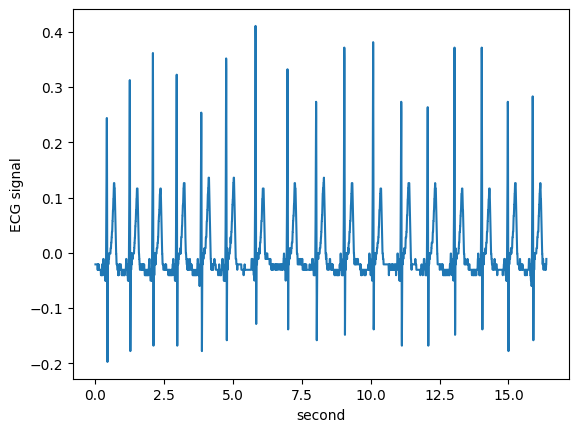

In [8]:
from matplotlib import pyplot as plt
import numpy as np

print(
    f"Beat label of the data sample:"
    f" {datasets.icentia11k.ds_beat_names[data[1]]}"
)
_ = plt.plot(np.arange(len(data[0]))/250, data[0])
_ = plt.xlabel('second')
_ = plt.ylabel('ECG signal')

The `beat_generator` is used to create a `tensorflow` `Dataset` object. The following code creates a `Dataset` that contains 2048 training data samples from Patient#0, each training data sample with frame size 2048.

In [9]:
dataset = datasets.beat_dataset(
    db_dir=DEMO_DATA_DIR, patient_ids=[0], frame_size=2048,
    unzipped=True, samples_per_patient=2048)
dataset.element_spec

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


(TensorSpec(shape=(2048, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

### Fine-tuning Dataset
The fine-tuning dataset is the "AF Classification from a Short Single Lead ECG Recording: The PhysioNet/Computing in Cardiology Challenge 2017" and freely available online for download <cite data-cite="PhysioNet:2000">[8]</cite><cite data-cite="Clifford:2017we">[9]</cite>.

- Source of the data
  - [Raw](https://physionet.org/content/challenge-2017/1.0.0/).
- Statistics
  - 8528 short ECG recordings.
  - Each ECG recording duration is 9 to 60 seconds with 300 Hz sampling rate.
  - Each ECG recording is labeled with one of the following classes: AF, Normal, Other or Noise (too noisy to classify).
- Data Downloading
  - The `train2017.zip` file needs to be extracted somewhere.
  - The files within need to be extracted and then preprocessed.
  - Preprocessing involves:
    - Resampling to 250 Hz to match the sample rate of the pre-training dataset.
    - Padding records to 65 seconds.
    - Standardizing the data using mean and standard deviation computed on the entire dataset.

#### Preparation

The `get_challenge17_data` function ([source](https://github.com/myles-i/DLH_TransferLearning/blob/master/finetuning/datasets.py#L9)) in the authors' code both extracts and pre-processes the PhysioNet dataset. We split the data extraction and pre-processing steps and saved the extracted data. This lets us have the flexibility of pre-processing without data extraction in every run. The below cell demonstrates an example of data pre-processing.

In [10]:
%%time
%%capture
# Downloads the raw PhysioNet record and label pickles, the output of
# extraction.
!gdown 1lI7lTZltRj_zQtYM1UcidZnSAQilPJSg -O {DEMO_DATA_DIR} --folder

CPU times: user 24.7 ms, sys: 6.23 ms, total: 30.9 ms
Wall time: 4.12 s


Note that downloading the extracted data took less than 10 seconds. We experienced 45 minutes for the data extraction, thus splitting the original `get_challenge17_data` function made our fine-tuning data preparation much more efficient.

In [11]:
import functools

import numpy as np

from finetuning import datasets
from transplant.datasets import physionet


def extract_challenge17_data(db_dir, verbose=False):
    # This is the author's extraction code
    records, labels = physionet.read_challenge17_data(db_dir, verbose=verbose)
    return records, labels


def process_extracted_challenge17_data(
    records, labels, fs=None, pad=None, normalize=False, verbose=False):
    """
    This is our code that performs pre-processing only.

    Args:
        records: See extract_challenge17_data.
        labels: See extract_challenge17_data.
        fs (int): Sampling rate.
        pad (int): Length that each record should be padded to (or truncated)
            pad / fs will give the approximate length in seconds.
        normalize (bool): Whether to standardize the records using mean and s.d.
            computed over the entire dataset. Note that the mean and s.d. have
            already been provided by the authors.
    """
    if normalize:
        normalize = functools.partial(
            physionet.normalize_challenge17, inplace=True)
    # This is the author's preprocessing code
    data_set = datasets._prepare_data(
        records,
        labels,
        normalize_fn=normalize,
        fs=fs,
        pad=pad,
        verbose=verbose)
    return data_set

In [12]:
%%time
from transplant.utils import load_pkl

records = load_pkl(f"{DEMO_DATA_DIR}/records.pkl")["data"]
labels = load_pkl(f"{DEMO_DATA_DIR}/labels.pkl")["data"]
physionet_data = process_extracted_challenge17_data(
    records,
    labels,
    fs=250,
    pad=16384,
    normalize=True,
    verbose=True,
)

Resampling records: 100%|██████████| 8528/8528 [00:03<00:00, 2269.68it/s]


CPU times: user 6.72 s, sys: 1.33 s, total: 8.05 s
Wall time: 8.02 s


#### Exploration

Labels are in the form one-hot encoded arrays. The labels `A`, `N`, `O` and `~` represent AF, Normal, Other and Noise, respectively.

The distribution of label values is shown below. Note that less than 10% of the data is labeled AF.

In [13]:
print(f'Shape of the fine-tuning data labels: {labels.shape}')
labels.value_counts()

Shape of the fine-tuning data labels: (8528, 4)


A  N  O  ~
0  1  0  0    5050
   0  1  0    2456
1  0  0  0     738
0  0  0  1     284
Name: count, dtype: int64

The `_prepare_data()` function packs ECG signals (resampled and padded) and labels into a dictonary ready to be consumed by `train_test_split` in `sklearn`. To save data pre-processing time in the fine-tuning precedure, we split the pre-processed data (i.e. the `physionet_data` variable) into train and test sets and saved them in pickle form.

In [14]:
print(f'PhysioNet data summary:')
print(f'Number of samples: {len(physionet_data["x"])}')
print(f"labels: {physionet_data['classes']}")
print(f'Dimensions of a sample: {physionet_data["x"][0].shape}')
# TODO: are we plotting this record id or can we delete this print statement?
print(
    f'Record id {physionet_data["record_ids"][0]} one-hot encoded label:'
    f' {physionet_data["y"][0]}'
)

PhysioNet data summary:
Number of samples: 8528
labels: ['A' 'N' 'O' '~']
Dimensions of a sample: (16384, 1)
Record id A00001 one-hot encoded label: [0 1 0 0]


Record id: A00004
One-hot encoded label: [1 0 0 0]


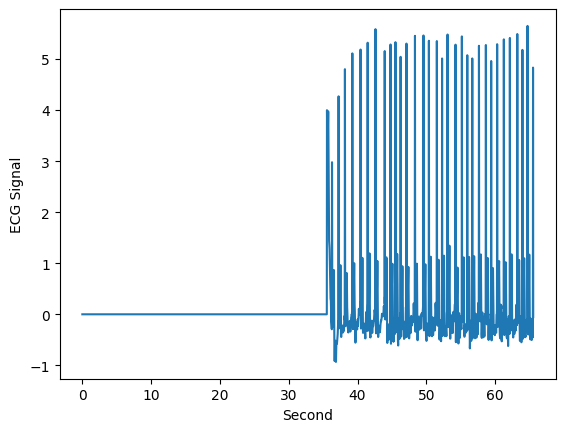

In [15]:
print(f'Record id: {physionet_data["record_ids"][3]}')
print(f'One-hot encoded label: {physionet_data["y"][3]}')
_ = plt.plot(np.arange(physionet_data["x"][3].shape[0])/250, physionet_data["x"][3])
_ = plt.xlabel('Second')
_ = plt.ylabel('ECG Signal')

## Model Used By Authors
In this project, the CNN model of choice is ResNet-18v2. We used the 1-D ResNet-18v2 implemented in the paper's Github repo to reproduce the paper's result.

We show how to use paper author's code to create a 1-D ResNet-18v2 for beat classification in pre-training and AF classification in fine-tuning.

* Model architecture
  * 18 layers
  * Input layer consists of convolution layer with 64 filters, kernel size=3 and stride=2. The output of the convolution layer passes through batch norm, ReLu and maxpooling layers sequentially.
  * Output layer is a classifier consisting of a densely-connected layer followed by softmax function.
  * The middle 16 layers consist of 8 residual blocks. A residual block consists of the following two components and outputs the sum of the two components' outputs.
    1. Two convolution layers, each followed by batch norm and ReLu.
    2. A shortcut that passes the input through a convolution layer followed by batch norm.
  * Configurations of the residual blocks
    * 1st and 2nd: 64 filters, kernel size=7, strides=2 and 1, respectively
    * 3rd and 4th: 128 filters, kernel size=5, strides=2 and 1, respectively
    * 5th and 6th: 256 filters, kernel size=5, strides=2 and 1, respectively
    * 7th and 8th: 512 filters, kernel size=3, strides=2 and 1, respectively
  * Detail [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/transplant/modules/resnet1d.py).
* Pre-training objectives
  * Loss function: [Sparse Categorical Cross Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
    * `from_logits=True`
    * All other parameters are set to their default values.
  * Optimizer: [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
    * `learning_rate`: 0.001 (default)
    * `beta_1`: 0.9
    * `beta_2`: 0.98
    * All other parameters are set to their default values.
  * Metric: [Sparse Categorical Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy)
* Fine-tuning objectives
  * Loss function: [Categorical Cross Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)
    * All parameters are set to their default values.
  * Optimizer: [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
    * `learning_rate`: 0.001 (default)
    * All other parameters are set to their default values.
  * Metrics:
    * [Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/CategoricalAccuracy)
    * Macro F1. See our `my_f1()` function below.




### Pre-training 1-D ResNet-18v2
Below we construct the pre-training ResNet-18v2 and show its structure.

In [16]:
import tensorflow as tf

from transplant.modules.resnet1d import ResNet
from transplant.datasets import icentia11k
from transplant.modules.utils import build_input_tensor_from_shape


resnet = ResNet(
    num_outputs=None,
    blocks=(2, 2, 2, 2),
    kernel_size=(7, 5, 5, 3),
    include_top=False
)

feature_extractor = tf.keras.Sequential([
    resnet,
    tf.keras.layers.GlobalAveragePooling1D()
])

num_classes = len(icentia11k.ds_beat_names)  # 5

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')]
)

# Initialize the weights of the model
train_data = dataset.batch(32)
input_shape, _ = tf.compat.v1.data.get_output_shapes(train_data)
input_dtype, _ = tf.compat.v1.data.get_output_types(train_data)
inputs = build_input_tensor_from_shape(
    input_shape,
    dtype=input_dtype,
    ignore_batch_dim=True
)
model(inputs)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512)               4492480   
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
Total params: 4495045 (17.15 MB)
Trainable params: 4485445 (17.11 MB)
Non-trainable params: 9600 (37.50 KB)
_________________________________________________________________


### Fine-tuning 1-D ResNet-18v2

The fine-tuning CNN model in the paper is the pre-training model with its output layer replaced with a fully connected layer that matches the classes of the PhysioNet 2017 dataset and has randomly initialized weights. Below is a demonstration to construct fine-tuning CNN model. Note the model's number of parameters is identical to that of the pre-training CNN, and the output layer has four outputs, instead of five.

In [17]:
resnet2 = ResNet(
    num_outputs=None,
    blocks=(2, 2, 2, 2),
    kernel_size=(7, 5, 5, 3),
    include_top=False
)

ft_model = tf.keras.Sequential([
    resnet2,
    tf.keras.layers.GlobalAveragePooling1D()
])

# Initialize the weights of the model
inputs = tf.keras.layers.Input(
    physionet_data['x'].shape[1:], dtype=physionet_data['x'].dtype
)
ft_model(inputs)

# Load pre-training weights, if any
pre_trained_weights = None
if pre_trained_weights:
    ft_model.load_weights(pre_trained_weights)

# Replace output layer
num_classes = len(physionet_data['classes'])  # 4
ft_model.add(
    tf.keras.layers.Dense(num_classes, activation='softmax', name='new_dense')
)

ft_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')]
)
ft_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_1 (ResNet)          (None, 512, 512)          4492480   
                                                                 
 global_average_pooling1d_1  (None, 512)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 new_dense (Dense)           (None, 4)                 2052      
                                                                 
Total params: 4494532 (17.15 MB)
Trainable params: 4484932 (17.11 MB)
Non-trainable params: 9600 (37.50 KB)
_________________________________________________________________


## Training

### Hyperparameters

TODO Report at least 3 types of hyperparameters such as learning rate, batch size, hidden size, dropout.

There is already some info in model section, move it to here.

#### TODO Pre-training

* Optimizer: [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
    * `learning_rate`: 0.001 (default)
    * `beta_1`: 0.9
    * `beta_2`: 0.98
    * All other parameters are set to their default values.
* Batch size: 512
* Hidden size: Please refer to the "Models Used By Authors" section for details.

#### Fine-tuning

* Optimizer: [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
    * `learning_rate`: 0.001 (default)
    * All other parameters are set to their default values.
* Batch size: 128
    * This size was chosen to maximize the GPU RAM usage of the V100 GPU on Google Colab.
* Hidden size: Please refer to the "Models Used By Authors" section for details.

### Computational Requirements

TODO Report at least 3 types of requirements such as type of hardware, average runtime for each epoch, total number of trials, GPU hrs used, # training epochs
Training code

---
For the full pre-training and fine-tuning processes, we use Google Colab Pro, V100 GPU (16 GB RAM).



#### Pre-training

* Type of Hardware: V100 GPU
    - Batch size of 512 used to fully utilize the 16 GB of RAM on the V100 GPU.
    - However, our training rate has been limited by not by the GPU speed, but the I/O time required to load/unzip the data files from disk.
    - We experimented with using A100 GPUs which has more RAM (i.e. larger batch size) and is generally faster. But we were unable to get significant speed improvements to justify the extra hourly cost of the A100 GPU.
* Average runtime for each epoch: **TODO**
* Total number of trials:
* GPU hours used: 2 hours, 30 minutes. **TODO this little?s** 
    - Frame size 4096
    - Training on 2048 patient data (about 20% of the Icentia11K dataset)
* Number of training epochs: **TODO**

Also note that during pre-training, we saved 16 checkpoints to be able to study how fine-tuning on different amounts of pre-training affects the final model's performance after fine-tuning.

#### TODO remove text below this line if happy with the format above.

---
During pre-training, we chose a batch size of 512 to fully utilize the 16 GB of RAM on the V100 GPU. However, our training rate has been limited by not by the GPU speed, but the I/O time required to load/unzip the data files from disk. Experimenting with using A100 GPUs which has more RAM (i.e. larger batch size) and is generally faster, we were unable to get significant speed improvements to justify the extra hourly cost of the A100 GPU.

With a frame size of 4096, loading 4096 samples per patient and a batch size of 512, training on 2048 patient data (about 20%) took 2 hours and 30 minutes. 



#### Fine-tuning

* Type of Hardware: V100 GPU
    - Batch size of 128 used to fully utilize the 16 GB of RAM on the V100 GPU.
    - Unlike in pre-training, we did not experience I/O overhead during training as the processed PhysioNet train and test data (pickles) were able to fit into RAM.
* Average runtime for each epoch: Between 21 to 22 seconds.
* Total number of trials: 30
    - 10 trials for each of the three scenarios: random, 10% and 20%.
* GPU hours used: About 13.7 hours total.
    - Random: 5.3 hours
    - 10%: 4.1 hours
    - 20%: 4.3 hours 
* Number of training epochs: Maximum 200 per trial, but in practice, saw early stopping by 80 epochs.
    - Training for a single trial would typically complete within 30 minutes.

### Training Code

#### [TODO not sure needed, the command line api seems enough to show]Pre-training
For beat classification pre-training, a checkpoint function is created to monitor training loss and save model weights of each epoch. The below cell demonstrates pre-training with a small dataset.

* Note that the model weights of each epoch are saved for fine-tuning model initialization.
* Also note that in `keras` and the way the authors implemented the pre-training step, 1 epoch is defined by batch size and steps-per-epoch (it does not imply training on the entire dataset once).

In [19]:
DRAFT_DEMO_JOB = JOB_DIR + '/draft_demo'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(DRAFT_DEMO_JOB + '/epoch_{epoch:02d}' + '/model.weights'),
    monitor='loss',
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    verbose=1
)

_ = model.fit(
    train_data,
    steps_per_epoch=64,
    verbose=2,
    epochs=2,
    validation_data=None,
    callbacks=[checkpoint]
)

Epoch 1/2

Epoch 1: saving model to /tmp/jobs/draft_demo/epoch_01/model.weights
64/64 - 18s - loss: 0.2035 - acc: 0.9438 - 18s/epoch - 287ms/step
Epoch 2/2

Epoch 2: saving model to /tmp/jobs/draft_demo/epoch_02/model.weights
64/64 - 3s - loss: 0.0992 - acc: 0.9741 - 3s/epoch - 54ms/step


### Command Line API

The paper authors provide entrypoint scripts to run the entire pre-training and fine-tuning process with parameters of choice. The following is the high level description of how the scripts work.

#### Pre-training

The source code from the paper authors can be found [here](https://github.com/myles-i/DLH_TransferLearning/tree/master/pretraining).

1. Create train/validate data generator based on patient id and the number of samples per patient, both specified when calling the entrypoint.
2. A model is generated based on the model architectrue and pre-training task specified by the user.
3. Weights of the model are initialized. They can also be loaded from a weights file. For all pre-training in the project, we don't load weights.
4. Checkpoint function is created based on training metric. For pre-training, we use `loss` as training metric.
5. The model fits the train data. At the end of each training epoch, the checkpoint function is called for evaluation and save the model weights.

The paper uses 95% of the patient's ECG data. On average, the paper sample 4096 ECG frames per patient, which amounts to 42.8 million (11000x0.95x4096) training samples over the course of pre-training. For pre-training with 20% of the data used in paper, we use ECG data from 2048 patients and sample 4096 ECG frames per patient, resulting to roughly 8.4 million (2048x4096) training samples.

The following sample command calls the pre-training entrypoint to run pre-training with 20% of the data used in the paper.

* The command is easily adapted to run pre-training with 10% of the data in the paper.

```bash
!time python -m pretraining.trainer \
--job-dir "jobs/beat_classification_16epochs_to_20percent" \
--task "beat" \
--train {TRAIN_DATASET} \
--arch "resnet18" \
--epochs 16 \
--patient-ids `seq 0 2047 | paste -sd, -` \
--steps-per-epoch 1024 \
--samples-per-patient 4096 \
--batch-size 512 \
--frame-size 4096
```

Explanation of the less obvious parameters:

* `--job-dir`: Output directory, where check points and weights are saved.

* `--task`: Pre-training task, `beat` for Beat classification.

* `--patient-ids`: Patient id(s) whose ECG data to be used in pre-training.

  * Multiple patients can be specified by passing a space separated sequence of ids.

* `--frame-size`: Number of ECG samples, with 250Hz sampling rate, in a ECG frame.

To use all data: number of patients x samples_per_patient = epochs x batch_size x steps-per-epoch.

For demonstration, we run the script in a much smaller scale below:

In [20]:
PRETRAIN_JOB_DIR = DRAFT_DEMO_JOB + '/pretraining'

In [21]:
%%time
!python -m pretraining.trainer \
--job-dir {PRETRAIN_JOB_DIR} \
--task "beat" \
--train {DEMO_DATA_DIR} \
--arch "resnet18" \
--epochs 2 \
--patient-ids 0 \
--steps-per-epoch 8 \
--samples-per-patient 4096 \
--batch-size 256 \
--frame-size 1024 \
--unzipped True \
--seed 2024

2024-04-30 06:11:18.664724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 06:11:18.664773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 06:11:18.665919: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 06:11:19.636663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in /tmp/jobs/draft_demo/pretraining
Setting random state 2024
Building train data generators
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
2024-04-3


#### Fine-tuning

The source code from the paper authors can be found [here](https://github.com/myles-i/DLH_TransferLearning/tree/master/finetuning).

1. Train and test data set are already separated from the PhysioNet 2017 dataset, with a 80%/20% split, and are passed to the entrypoint. The validation dataset will be further separated from the train dataset based on user input.
2. A CNN model is generated based on the model architectrue specified by the user. Its output layer is fully connected with softmax activation.
3. Weights of the model are initialized. They can also be loaded from a weights file.
4. Checkpoint function is created based on validation metric. For fine-tuning, we use `f1` as the metric.
5. The model fits the train data. At the end of each training epoch, the checkpoint function is called for evaluation and saves the model weights with best macro F1 score on the validation set. Note that the model also is setup to end training early if the validation accuracy does not improve after 50 epochs.
6. The model is evaluated on the test set and the predicted probabilities are saved to a csv file.


The following sample command calls the fine-tuning entrypoint to run fine-tuning with **random initialization**.

```bash
python -m finetuning.trainer \
--job-dir {JOB_DIR} \
--train {FINETUNE_TRAIN} \
--test {FINETUNE_TEST} \
--val-size 0.0625 \
--val-metric "f1" \
--arch "resnet18" \
--batch-size 128 \
--epochs 200 \
--seed 2024 \
--verbose
```

Explanation of the less obvious parameters:

* `--job-dir`: Output directory, where checkpoints and weights are saved.
* `--val-size`: This is the percentage of the train set size to set aside for the validation set.
  * Note that the PhysioNet data was already split into 80% train, 20% test. The paper uses 5% of the full dataset for validation.
  * Math: $6.25\% * 80\% = 5\%$
* `--val-metric`: Metric to evaluate the model at the end of each epoch on the validation dataset.
* `--seed`: Random state used to split the train into smaller train and validation.

Below is a small scale demonstration of fine-tuning with random weight initialization. We first download fine-tuning train and test datasets.

In [22]:
%%capture
FINETUNE_TRAIN = DEMO_DATA_DIR + '/physionet_train.pkl'
FINETUNE_TEST = DEMO_DATA_DIR + '/physionet_test.pkl'
!gdown 10PVz1nmMaeIgxQ4sqDUeZlzhFVHOth5I -O {FINETUNE_TRAIN}
!gdown 10FKjncGOZD6_BBCBbvpBQbWvfCLj88MC -O {FINETUNE_TEST}

In [23]:
FINETUNE_JOB_DIR = DRAFT_DEMO_JOB + '/finetuning_random'

In [24]:
%%time
!python -m finetuning.trainer \
--job-dir {FINETUNE_JOB_DIR} \
--train {FINETUNE_TRAIN} \
--test {FINETUNE_TEST} \
--val-size 0.0625 \
--val-metric "f1" \
--arch "resnet18" \
--batch-size 128 \
--epochs 2 \
--seed 2024 \
--verbose

2024-04-30 06:13:08.166296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 06:13:08.166343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 06:13:08.167593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 06:13:09.160921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in /tmp/jobs/draft_demo/finetuning_random
Setting random state 2024
Loading train data from /tmp/data/final_demo/physionet_train.pkl ...
Split data into train 93.73% and validation 6.27%
Loading test data from /tmp

The following sample command uses the fine-tuning entrypoint to run fine-tuning with pre-training weights.
```bash
python -m finetuning.trainer \
--job-dir {JOB_DIR} \
--train {FINETUNE_TRAIN} \
--test {FINETUNE_TEST} \
--weights-file {WEIGHTS_FILE} \
--val-size 0.0625 \
--val-metric "f1" \
--arch "resnet18" \
--batch-size 128 \
--epochs 200 \
--seed 2024 \
--verbose
```

Largely the same command as the previous for fine-tuning a randomly initialized network. But with this addition.

* `--weights-file {WEIGHTS_FILE}`: Path to pre-trained weights or a checkpoint of the model to be used for model initialization.

Small scale demonstration below using weights obtained from pre-training using 20% of the Icentia11K dataset. We first download model weights from our experiments.

In [25]:
%%time
%%capture
!mkdir -p {JOB_DIR + '/finetune_baseline_65sec'}
!gdown 1Tl5CVIDoKFo37Q1FUwCVDqqb84lp-rRk \
    -O {JOB_DIR + '/finetune_baseline_65sec'} --folder

!mkdir -p {JOB_DIR + '/finetune_pretrain_20_weights_65sec'}
!gdown 1-A0AqZe9sanj-8MZnoX4TUAYWrgcUTlg \
    -O {JOB_DIR + '/finetune_pretrain_20_weights_65sec'} --folder

!mkdir -p {JOB_DIR + '/finetune_pretrain_10_weights_65sec'}
!gdown 1-363P8B28RZIBwwFVhDvB7suE3nasnji \
    -O {JOB_DIR + '/finetune_pretrain_10_weights_65sec'} --folder

CPU times: user 177 ms, sys: 31.7 ms, total: 208 ms
Wall time: 31.5 s


In [26]:
WEIGHTS_FILE = JOB_DIR \
    + '/finetune_pretrain_20_weights_65sec/best_model.weights'
FINETUNE_JOB_DIR = DRAFT_DEMO_JOB + '/finetuning_pretrained'

In [27]:
%%time
!python -m finetuning.trainer \
--job-dir {FINETUNE_JOB_DIR} \
--train {FINETUNE_TRAIN} \
--test {FINETUNE_TEST} \
--weights-file {WEIGHTS_FILE} \
--val-size 0.0625 \
--val-metric "f1" \
--arch "resnet18" \
--batch-size 128 \
--epochs 2 \
--seed 2024 \
--verbose

2024-04-30 06:17:03.309914: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 06:17:03.309965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 06:17:03.311296: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 06:17:04.280797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in /tmp/jobs/draft_demo/finetuning_pretrained
Setting random state 2024
Loading train data from /tmp/data/final_demo/physionet_train.pkl ...
Split data into train 93.73% and validation 6.27%
Loading test data from 

## TODO Evaluation

### TODO Pre-training

#### TODO Metrics descriptions


#### TODO Evaluation Code

### Fine-tuning

#### Metrics Descriptions

In fine-tuning, the paper uses macro F1 score for evaluating the model on the PhysioNet validation and test sets.


#### Evaluation Code

We define our macro F1 function `my_f1`. It is named like that because the paper authors define their F1 function named `f1` and we wish to avoid namespace collision. Additionally, our macro F1 function supports providing per-class F1 scores, which the **original** `f1` function does not support.
See also the analysis section for how we are using this metric in our results.

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def my_f1(y_true, y_prob, average='macro'):
    # set average=None to get per-class F1 scores.
    y_pred = y_prob >= np.max(y_prob, axis=1)[:, None]
    return f1_score(y_true, y_pred, average=average)

# Ablation Study (Hypothesis 3)
For the ablation study, we are pre-processing the data to produce a spectogram for each ECG signal and then passing this result into a 2-D ResNet-18v2. Then, the same pre-training and fine-tuning process from the paper is followed. The goal is to test how extensible the papers ideas are to other models. The work-in-progress notebook that includes building the model in `keras`, the data pre-processing function, the `keras` data generators, and running two epochs of pre-training.

**Fine-tuning is not yet complete:**

Current progress is in this [notebook](https://github.com/myles-i/DLH_TransferLearning/blob/master/jupyter_notebooks/explore_spectogram.ipynb).

Below, we explain the preprocessing and model in more detail:

### Ablation Preprocessing - spectogram
For the spectogram, the following parameters were chosen:

- window_size: 256 (~1 second)
- stride: 64 (~0.25 seconds)
- window type: hanning -> this is like a pre-defined convolution that isused to smooth the FFTs for each spectogram slice

After the spectogram for a data sample is computed, only the lower 32 frequency components (from 0-62.5 Hz) are selected to reduce the input size. This was chosen empirically and validated by reproducing the original signal with the filtered spectogram models.

The spectogram pre-processing and the data loaders for the pre-training can be found [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/transplant/datasets/icentia11k_spectogram.py).

Below, we show the raw ECG signal next to the spectogram of the same signal using our pre-processing function, and then use the spectogram pre-processor on the same ECG signal presented in the earlier "Data" section.


beat label: normal


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=256 is too large for input signal of length=1
  warnings.warn(
<ipython-input-31-d6d7f919b2d9>:16: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im1 = ax.imshow(np.abs(x[:,:,0]), cmap='viridis', aspect='auto')


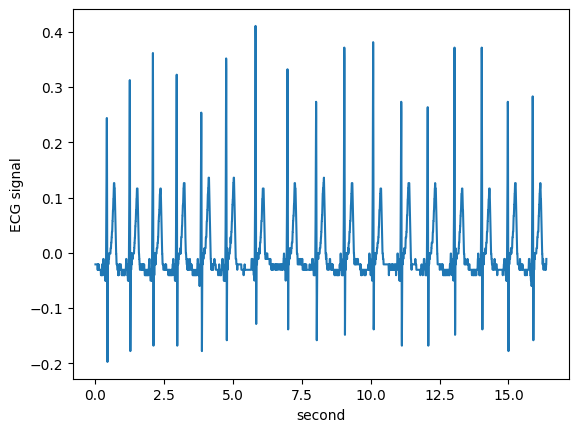

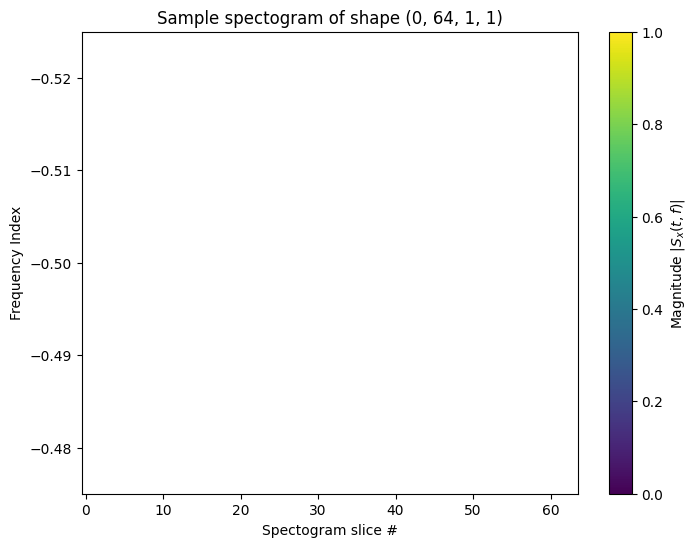

In [31]:
from pretraining import datasets
from transplant.datasets.icentia11k_spectogram import spectogram_preprocessor
# use raw data we grabbed earlier

# first lets plot the raw signal for comparison
print(f"beat label: {datasets.icentia11k.ds_beat_names[data[1]]}")
_ = plt.plot(np.arange(len(data[0]))/250, data[0])
_ = plt.xlabel('second')
_ = plt.ylabel('ECG signal')


# now lets calculate and plot the spectogra of this raw signal
x = spectogram_preprocessor(data[0], frame_size = 4096)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im1 = ax.imshow(np.abs(x[:,:,0]), cmap='viridis', aspect='auto')
fig.colorbar(im1, label="Magnitude $|S_x(t, f)|$")
ax.set_title(f"Sample spectogram of shape {x.shape}")
ax.set_xlabel("Spectogram slice #")
ax.set_ylabel("Frequency Index")
ax.invert_yaxis()
plt.show()



### Ablation Model: 2-D ResNet-18v2
The model chosen for the ablation study using spectograms is similar to the original model used, but is a 2-D ResNet-18v2. It is presented here:

* Model architecture
  * 18 layers
  * Input layer consists of convolution layer with 64 filters, kernel size=7x7 and stride=2. The output of the convolution layer passes through batch norm, ReLu and maxpooling layer sequentially.
  * The middle 16 layers consists of 8 residual blocks. A residual block consists of the following two components and outputs the sum of the two components' outputs.
    1. Two convolution layers, each followed by batch norm and ReLu
    2. A shortcut that passes the input through a convolution layer followed by batch norm.
  * Output layer is a classifier consisting of a densely-connected layer followed by softmax or sigmoid function.
  * Configurations of the residual blocks
    * 1st and 2nd: 64 filters, kernel size=3x3, strides=2 and 1, respectively.
    * 3rd and 4th: 128 filters, kernel size=3x3, strides=2 and 1, respectively.
    * 5th and 6th: 256 filters, kernel size=3x3, strides=2 and 1, respectively.
    * 7th and 8th: 512 filters, kernel size=3x3, strides=2 and 1, respectively.

* Pre-training objectives
  * The same as the original author's 1-D pre-training objectives.

* Fine-tuning objectives
  * The same as the original author's 1-D pre-training objectives (F1 score)

The code for the 2-D ResNet-18v2 can be found [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/transplant/modules/resnet2d.py).

This model is built and displayed below for reference:
  

In [32]:
from transplant.modules.resnet2d import ResNet18_2D
import transplant.datasets.icentia11k as icentia11k

num_classes = len(icentia11k.ds_beat_names)
model = ResNet18_2D(num_classes=num_classes)
model.build(input_shape=(None, 64, 64, 1))
model.compile(
    optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')]
)
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18_2d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization_2 (Bat  multiple                  256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBloc  multiple            

# Results

- Table of results (no need to include additional experiments, but main reproducibility result should be included)
- All claims should be supported by experiment results
- Discuss with respect to the hypothesis and results from the original paper
- Experiments beyond the original paper
- Each experiment should include results and a discussion


We used the pre-training entrypoint script and saved the model weights with 10% and 20% of the pre-training data used in paper. Then we ran the fine-tuning entrypoint script to perform fine-tuning and evaluate the model performance with random initilization and pre-training weights.

## Validation Macro F1 Comparison
We compare the macro F1 on the PhysioNet validation dataset over epoch between the model with random initialization weights and the model with pre-training weights.

This would be compared with Figure 3(a) in the paper.

Below we download for each model scenario the:
- Saved model weights.
- Training history containing validation macro F1 scores.
- Model predictions on the test set.

In [34]:
import pandas as pd
from matplotlib import pyplot as plt

# Already downloaded earlier.
random_result = pd.read_csv(JOB_DIR + '/finetune_baseline_65sec/history.csv')
pretrain_20_result = pd.read_csv(
    JOB_DIR + '/finetune_pretrain_20_weights_65sec/history.csv'
)
pretrain_10_result = pd.read_csv(
    JOB_DIR + '/finetune_pretrain_10_weights_65sec/history.csv'
)

plt.plot(
    random_result['epoch'], random_result['f1'],
    color='tab:red', label='Random'
)
plt.plot(
    pretrain_20_result['epoch'], pretrain_20_result['f1'],
    color='tab:blue', label='Pre-train 20'
)
plt.plot(
    pretrain_10_result['epoch'], pretrain_10_result['f1'],
    color='tab:green', label='Pre-train 10'
)
plt.xlabel('Epoch')
plt.ylabel('Validation Macro F1')
ax = plt.gca()
ax.set_xlim([0, 80])
ax.set_ylim([0.5, 1.0])
_ = plt.legend(loc='upper right')

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/data/finetune_baseline_65sec/history.csv'

### Analysis
With pre-training weights, the F1 scores stabilize much sooner than random initialization. The model with pre-training weights also outperforms the random initalization model for the most part.

## Test Macro F1 Comparison


### Demonstration of obtaining test predictions
The fine-tuning entrypoint performs inference on the test set using the model with the highest validation macro F1 score, and saves the result to a CSV file.

It is this CSV file that we will perform macro F1 evaluation.

### Evaluating test predictions with macro F1

The CSV file contains model predicted probabilities for each of the four classes and the actual class label. We preview the CSV file for the randomly initialized model.

In [35]:
random_preds = pd.read_csv(
    JOB_DIR + '/finetune_baseline_65sec/test_predictions.csv'
)
random_preds.head()

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/data/finetune_baseline_65sec/test_predictions.csv'

The paper authors provide a function to read the CSV and transform it into a format amenable to usage with `my_f1`. We make use of the function and show the macro F1 scores for each of the three scenarios.

In [36]:
from transplant.utils import read_predictions

test_df_random = read_predictions(
    JOB_DIR + '/finetune_baseline_65sec/test_predictions.csv'
)
test_df_pretrain_10 = read_predictions(
    JOB_DIR + '/finetune_pretrain_10_weights_65sec/test_predictions.csv'
)
test_df_pretrain_20 = read_predictions(
    JOB_DIR + '/finetune_pretrain_20_weights_65sec/test_predictions.csv'
)

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/data/finetune_baseline_65sec/test_predictions.csv'

In [ ]:
def get_test_f1(formatted_predictions):
    # Convenience function to compute macro F1 score.
    y_true = formatted_predictions['y_true']
    y_prob = formatted_predictions['y_prob']
    return my_f1(y_true, y_prob)

In [ ]:
test_f1_scores = pd.DataFrame.from_dict(
    {
        'random': get_test_f1(test_df_random),
        'pretrain_10': get_test_f1(test_df_pretrain_10),
        'pretrain_20': get_test_f1(test_df_pretrain_20),
    },
    orient='index',
    columns=['Macro F1'],
).reset_index(names='Scenario')

test_f1_scores

,Scenario,Macro F1
0,random,0.714916
1,pretrain_10,0.753109
2,pretrain_20,0.781280


# TODO Discussion

## Reflection on the Experimental Results

Implications of the experimental results, whether the original paper was reproducible, and if it wasn't, what factors made it irreproducible

## TODO What Was Easy

TODO 


## TODO What Was Difficult

TODO



## Recommendations For Reproducibility

It would be a very good idea for such paper code to provide a **completely** specified environment configuration. The [original](https://github.com/kweimann/ecg-transfer-learning/blob/master/requirements.txt) `requirements.txt` provided did not specify all packages used, the exact versions used, nor performed complete pinning of dependencies. 

For example, the `samplerate` dependency in the original requirements was deprecated when we started the project. We had to remove it and [implement the code from scratch](https://github.com/myles-i/DLH_TransferLearning/commit/38190172af5092d1ac72e8b705b0bc58b169bd3b).

# Public GitHub Repo
The repo with our code is available on [Github](https://github.com/myles-i/DLH_TransferLearning/tree/master). Specifically, the reports are located [here](https://github.com/myles-i/DLH_TransferLearning/tree/master/report).

# References

1. Weimann, K., Conrad, T.O.F. Transfer learning for ECG classification. Sci Rep 11, 5251 (2021). https://doi.org/10.1038/s41598-021-84374-8
2. Kachuee, M., Fazeli, S., & Sarrafzadeh, M. ECG heartbeat classification: a deep transferable representation. in _2018 IEEE International Conference on Healthcare Informatics (ICHI)._ https://doi.org/10.1109/ichi.2018.00092 (2018).
3. Rahhal, M. A. _et al._ Deep learning approach for active classification of electrocardiogram signals. _Inf. Sci._ **345**, 340–354. https://doi.org/10.1016/j.ins.2016.01.082 (2016).
4. Rajan, D., Beymer, D., & Narayan, G. Generalization Studies of Neural Network Models for Cardiac Disease Detection Using Limited Channel ECG (2019). arXiv:1901.03295
5. J. Huang, B. Chen, B. Yao and W. He, “`ECG Arrhythmia Classification Using STFT-Based Spectrogram and Convolutional
 Neural Network`,” in IEEE Access, vol. 7
6. Shawn Tan, Satya Ortiz-Gagné, Nicolas Beaudoin-Gagnon, Pierre Fecteau, Aaron Courville, Yoshua Bengio, and Joseph Paul Cohen. Icentia11k single lead continuous raw electrocardiogram dataset (version 1.0). https://doi.org/10.13026/kk0v-r952, April 2022.
7. Tan, S. _et al._ Icentia11K: An Unsupervised Representation Learning Dataset for Arrhythmia Subtype Discovery (2019). arXiv:arXiv:1910.09570
8. Goldberger, A.L. _et al._ PhysioBank, PhysioToolkit,and PhysioNet: components of a new research resource for complex physiologic signals. _Circulation_ **101**, e215–e220. https://doi.org/10.1161/01.CIR.101.23.e215 (2000).
9. Clifford, G.D. _et al._ AF Classification from a short single lead ECG recording: thePhysioNet/computing in cardiology challenge 2017. _Comput. Cardiol._ (2017).

In [ ]:
# Convert to html (to then be converted to pdf separately)
# !jupyter nbconvert --to html ../../content/DL4H_Team_1_draft.ipynb